In [1]:
### Celda para ejecutar en google Colab

from google.colab import drive
import os
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Multiples_anotadores/Notebooks'

os.chdir(root_path)
#!pip install -r requirements.txt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np 
import pandas as pd 
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import sklearn.datasets as dt
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import OneHotEncoder 
from sklearn.base import BaseEstimator, ClassifierMixin

Instructions for updating:
non-resource variables are not supported in the long term


Se carga la base de datos iris del paquete ``` sklearn.datasets ```.



In [3]:
data = dt.load_iris()
x_orig, y_orig = data.data, data.target
print(x_orig.shape)
print(y_orig.shape)

(150, 4)
(150,)


Transformar las entradas usando notación 1 de k


In [4]:
# Creating the One Hot Encoder 
oneHot = OneHotEncoder() 

# Encoding y_orig 
y_orig=y_orig.reshape(-1, 1)
oneHot.fit(y_orig)
y = oneHot.transform(y_orig).toarray() 


Se identifican valores de interés y se definen los parámetros para el algoritmo de optimización. Adicionalmente se aplica un kernel gaussiano (```rbf_kernel```) a X y se le añade una columna de unos para tener en cuenta el bias.


In [5]:
K = rbf_kernel(x_orig)
m, n = K.shape 
x = np.concatenate([K,np.reshape(np.ones(m),[m,1])],1)
ind = np.arange(m)
  
alpha, epochs, batch_size = 0.0015, 2000, 15

print('Learning Rate =', alpha) 
print('Number of Epochs =', epochs) 
print('Batch Size =', batch_size) 
print('Classes = ', y.shape[1])
print('Samples =', m) 
print('Features =', n) 

Learning Rate = 0.0015
Number of Epochs = 2000
Batch Size = 15
Classes =  3
Samples = 150
Features = 150


Se definen las variables que se usarán en la sesión de tensorflow

In [6]:
X = tf.placeholder(tf.float32, [None, n+1]) 
Y = tf.placeholder(tf.float32, [None, np.unique(y_orig).size]) 
  
# Trainable Variable Weights 
B = tf.Variable(tf.zeros([n+1,np.unique(y_orig).size]))

Se definen las expresiones que serán evaluadas, así como el algoritmo de optimización y el inicializador de variables

In [7]:
# Hypothesis 
Y_hat = tf.nn.softmax(tf.matmul(X, B)) 
  
# Sigmoid Cross Entropy Cost Function
cost = tf.nn.softmax_cross_entropy_with_logits_v2( 
                    logits = Y_hat, labels = Y) 
  
# Gradient Descent Optimizer 
optimizer = tf.train.GradientDescentOptimizer( 
         learning_rate = alpha).minimize(cost) 
  
# Global Variables Initializer 
init = tf.global_variables_initializer()

Se inicia la sesión de tesorflow y se entrena el algoritmo de optimización usando mini batches


In [8]:
# Starting the Tensorflow Session 
with tf.Session() as sess: 
      
    # Initializing the Variables 
    sess.run(init) 
      
    # Lists for storing the changing Cost and Accuracy in every Epoch 
    cost_history, accuracy_history = [], [] 
      
    # Iterating through all the epochs 
    for epoch in range(epochs): 
        #print(epoch)
        cost_per_epoch = 0
        random.shuffle(ind)     
        total_batch = int(m/batch_size)
        avg_cost = 0
        # Loop over all batches
        for i in range(total_batch):
            idx = ind[i*batch_size:((i+1)*batch_size)]
            batch_xs, batch_ys = x[idx,:], y[idx,:]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
          
        # Calculating accuracy on current Epoch 
        correct_prediction = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1)) 
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 
          
        # Storing Cost and Accuracy to the history 
        cost_history.append(avg_cost) 
        accuracy_history.append(accuracy.eval({X : x, Y : y}) * 100) 
          
        # Displaying result on current Epoch 
        #if epoch % 100 == 0 and epoch != 0: 
           # print("Epoch " + str(epoch) + " Avg Cost: "
          #                  + str(cost_history[-1])) 
      
    Weight = sess.run(B) # Optimized Weight  
    
    # Final Accuracy 
    correct_prediction = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1)) 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 
    print(accuracy)
   # print("\nAccuracy:", accuracy_history[-1], "%")



Tensor("Mean_2000:0", shape=(), dtype=float32)


Se grafica el acierto de clasificación y la evolución de la función de costo para cada ciclo

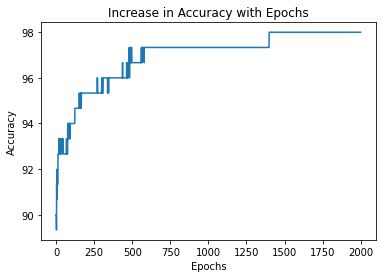

98.00000190734863


In [9]:
plt.plot(list(range(epochs)), accuracy_history) 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.title('Increase in Accuracy with Epochs')


plt.show() 
print(accuracy_history[-1])

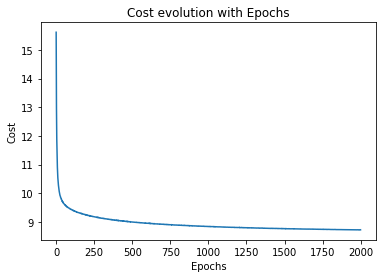

In [10]:
plt.plot(list(range(epochs)), np.sum(cost_history,axis =1)) 
plt.xlabel('Epochs') 
plt.ylabel('Cost') 
plt.title('Cost evolution with Epochs')
plt.show() 